In [1]:
import altair as alt
import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
pd.set_option("display.max_columns", 25)
pd.set_option("display.max_rows", 200)
pd.options.display.float_format = "{:,.2f}".format

## Import and format CRP contributions data for 2018

In [2]:
forbes_contributions = pd.read_csv("https://dash.fivetwentyseven.com/api/queries/599/results.csv?api_key=DGS1Mwb6QGEMRUkeusDTyytToptOKx4eCCy8Wpq2",
                                   dtype={"cycle": "category", "state": "category", "recipcode": "category", "realcode": "category",
                                   "type": "category", "gender": "category", "source": "category", "contributor_id": "category"})
forbes_contributions["date"] = pd.to_datetime(forbes_contributions["date"])
forbes_contributions["date"] = pd.DatetimeIndex(forbes_contributions["date"]).normalize()
forbes_contributions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7504 entries, 0 to 7503
Data columns (total 25 columns):
cycle             7504 non-null category
fectransid        7504 non-null int64
contribid         7504 non-null object
contrib           7504 non-null object
recipid           7504 non-null object
orgname           7032 non-null object
ultorg            735 non-null object
realcode          7504 non-null category
date              7504 non-null datetime64[ns]
amount            7504 non-null int64
street            0 non-null float64
city              7503 non-null object
state             7504 non-null category
zip               7504 non-null object
recipcode         7504 non-null category
type              7504 non-null category
cmteid            7504 non-null object
otherid           837 non-null object
gender            7504 non-null category
microfilm         7504 non-null object
occupation        7217 non-null object
employer          6916 non-null object
source            750

## Import and format CRP contributions data for 2014

In [3]:
forbes_contributions_14 = pd.read_csv("https://dash.fivetwentyseven.com/api/queries/600/results.csv?api_key=FfDdgMSONMliaHYyL85d3E4Ty2XaOa0fda7jjpbk",
                                      dtype={"cycle": "category", "state": "category", "recipcode": "category", "realcode": "category",
                                   "type": "category", "gender": "category", "source": "category", "contributor_id": "category"})
forbes_contributions_14["date"] = pd.to_datetime(forbes_contributions_14["date"])
forbes_contributions_14["date"] = pd.DatetimeIndex(forbes_contributions_14["date"]).normalize()
forbes_contributions_14.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8428 entries, 0 to 8427
Data columns (total 25 columns):
cycle             8428 non-null category
fectransid        8428 non-null int64
contribid         8428 non-null object
contrib           8428 non-null object
recipid           8428 non-null object
orgname           8031 non-null object
ultorg            615 non-null object
realcode          8428 non-null category
date              8428 non-null datetime64[ns]
amount            8428 non-null int64
street            0 non-null float64
city              8424 non-null object
state             8428 non-null category
zip               8428 non-null object
recipcode         8428 non-null category
type              8428 non-null category
cmteid            8428 non-null object
otherid           360 non-null object
gender            8428 non-null category
microfilm         8428 non-null object
occupation        7959 non-null object
employer          7593 non-null object
source            842

## Join committees and categories

In [4]:
committees = pd.read_csv("cmtes18.txt", sep=",", header=None, names=["cycle", "cmteid", "pacshort", "affiliate",
                                                                     "ultorg", "recipid", "recipcode", "feccandid",
                                                                     "party", "primcode", "source", "sensitive",
                                                                     "foreign", "active"],
                         dtype={"cycle": "category", "recipcode": "category", "party": "category", "primcode": "category",
                                 "source": "category", "sensitive": "category", "foreign": "category",
                                 "active": "category"}, quotechar="|")
committees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18100 entries, 0 to 18099
Data columns (total 14 columns):
cycle        18100 non-null category
cmteid       18100 non-null object
pacshort     17819 non-null object
affiliate    2109 non-null object
ultorg       8895 non-null object
recipid      18100 non-null object
recipcode    12192 non-null category
feccandid    6632 non-null object
party        9217 non-null category
primcode     8883 non-null category
source       8876 non-null category
sensitive    12187 non-null category
foreign      18100 non-null category
active       18100 non-null category
dtypes: category(8), object(6)
memory usage: 1.0+ MB


In [5]:
categories = pd.read_csv("CRP_Categories.txt", sep="\t", header=7, dtype={"Catcode": "category", "Catname": "category",
                                                                          "Catorder": "category", "Industry": "category",
                                                                          "Sector": "category", "Sector Long": "category"})
categories.rename(columns={"Catcode": "catcode", "Catname": "catname", "Catorder": "catorder", "Industry": "industry",
                           "Sector": "sector", "Sector Long": "sectorlong"}, inplace=True)
categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459 entries, 0 to 458
Data columns (total 6 columns):
catcode       459 non-null category
catname       459 non-null category
catorder      459 non-null category
industry      459 non-null category
sector        459 non-null category
sectorlong    459 non-null category
dtypes: category(6)
memory usage: 44.0 KB


In [6]:
committees = committees.merge(categories, how="left", left_on="primcode", right_on="catcode")
committees["primcode"] = committees["primcode"].astype("category")
committees.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18100 entries, 0 to 18099
Data columns (total 20 columns):
cycle         18100 non-null category
cmteid        18100 non-null object
pacshort      17819 non-null object
affiliate     2109 non-null object
ultorg        8895 non-null object
recipid       18100 non-null object
recipcode     12192 non-null category
feccandid     6632 non-null object
party         9217 non-null category
primcode      8883 non-null category
source        8876 non-null category
sensitive     12187 non-null category
foreign       18100 non-null category
active        18100 non-null category
catcode       8849 non-null category
catname       8849 non-null category
catorder      8849 non-null category
industry      8849 non-null category
sector        8849 non-null category
sectorlong    8849 non-null category
dtypes: category(14), object(6)
memory usage: 1.3+ MB


## Join the Forbes 400 contributions during the 2018 election cycle to the committees.

In [7]:
forbes_contributions = forbes_contributions.merge(committees, how="left", on="cmteid")
forbes_contributions.drop(["cycle_y", "ultorg_y", "recipcode_y", "source_y"], axis=1, inplace=True)
forbes_contributions.rename(columns={"cycle_x": "cycle", "recipid_x": "recipid", "ultorg_x": "ultorg", "recipcode_x": "recipcode", "source_x": "source"}, inplace=True)
forbes_contributions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7504 entries, 0 to 7503
Data columns (total 40 columns):
cycle             7504 non-null category
fectransid        7504 non-null int64
contribid         7504 non-null object
contrib           7504 non-null object
recipid           7504 non-null object
orgname           7032 non-null object
ultorg            735 non-null object
realcode          7504 non-null category
date              7504 non-null datetime64[ns]
amount            7504 non-null int64
street            0 non-null float64
city              7503 non-null object
state             7504 non-null category
zip               7504 non-null object
recipcode         7504 non-null category
type              7504 non-null category
cmteid            7504 non-null object
otherid           837 non-null object
gender            7504 non-null category
microfilm         7504 non-null object
occupation        7217 non-null object
employer          6916 non-null object
source            750

## Join the Forbes 400 contributions during the 2014 election cycle to the committees.

In [8]:
forbes_contributions_14 = forbes_contributions_14.merge(committees, how="left", on="cmteid")
forbes_contributions_14.drop(["cycle_y", "ultorg_y", "recipcode_y", "source_y"], axis=1, inplace=True)
forbes_contributions_14.rename(columns={"cycle_x": "cycle", "recipid_x": "recipid", "ultorg_x": "ultorg", "recipcode_x": "recipcode", "source_x": "source"}, inplace=True)
forbes_contributions_14.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8428 entries, 0 to 8427
Data columns (total 40 columns):
cycle             8428 non-null category
fectransid        8428 non-null int64
contribid         8428 non-null object
contrib           8428 non-null object
recipid           8428 non-null object
orgname           8031 non-null object
ultorg            615 non-null object
realcode          8428 non-null category
date              8428 non-null datetime64[ns]
amount            8428 non-null int64
street            0 non-null float64
city              8424 non-null object
state             8428 non-null category
zip               8428 non-null object
recipcode         8428 non-null category
type              8428 non-null category
cmteid            8428 non-null object
otherid           360 non-null object
gender            8428 non-null category
microfilm         8428 non-null object
occupation        7959 non-null object
employer          7593 non-null object
source            842

## Add a liberal-conservative category.

In [9]:
forbes_contributions["liberal_conservative"] = np.where(forbes_contributions["catname"].str.contains("democratic", case=False), "liberal/democratic",
                                       np.where(forbes_contributions["catname"].str.contains("republican", case=False), "conservative/republican", "other"))
forbes_contributions_14["liberal_conservative"] = np.where(forbes_contributions_14["catname"].str.contains("democratic", case=False), "liberal/democratic",
                                       np.where(forbes_contributions_14["catname"].str.contains("republican", case=False), "conservative/republican", "other"))

## The first House vote on the bill was held November 16. Let's categorize each contribution as before, after or on that date.

In [10]:
forbes_contributions["pre_post_vote"] = np.where(forbes_contributions["date"] < "2017-11-16", "pre-vote",
                                                 np.where(forbes_contributions["date"] > "2017-11-16", "post-vote",
                                                          np.where(forbes_contributions["date"] == "2017-11-16", "day of vote",
                                                                   "other")))
forbes_contributions_14["pre_post_vote"] = np.where(forbes_contributions_14["date"] < "2013-11-16", "pre-vote",
                                                 np.where(forbes_contributions_14["date"] > "2013-11-16", "post-vote",
                                                          np.where(forbes_contributions_14["date"] == "2013-11-16", "day of vote",
                                                                   "other")))

## How does this play out over the 2018 cycle?

In [12]:
grouped_by_category = forbes_contributions.groupby(["liberal_conservative", "pre_post_vote"]).agg({"contributor_id": "nunique", "fectransid": "count", "amount": sum}).reset_index()
grouped_by_category.rename(columns={"contributor_id": "num_donors", "fectransid": "num_contributions", "amount": "total_amount"}, inplace=True)
grouped_by_category["pct_total_amount"] = grouped_by_category["total_amount"] / grouped_by_category["total_amount"].sum()
grouped_by_category[grouped_by_category["total_amount"] > 0].sort_values(["liberal_conservative", "pre_post_vote"], ascending=[True, False]).reset_index(drop=True)

,liberal_conservative,pre_post_vote,num_donors,num_contributions,total_amount,pct_total_amount
0,conservative/republican,pre-vote,158,2218,36028128,0.31
1,conservative/republican,post-vote,140,1500,26401669,0.23
2,conservative/republican,day of vote,2,3,6400,0.00
3,liberal/democratic,pre-vote,126,1698,12943501,0.11
4,liberal/democratic,post-vote,107,1637,30303191,0.26
5,liberal/democratic,day of vote,4,4,50000,0.00
6,other,pre-vote,99,235,2322619,0.02
7,other,post-vote,90,209,7436816,0.06


## And in 2014?

In [13]:
grouped_by_category_14 = forbes_contributions_14.groupby(["liberal_conservative", "pre_post_vote"]).agg({"contributor_id": "nunique", "fectransid": "count", "amount": sum}).reset_index()
grouped_by_category_14.rename(columns={"contributor_id": "num_donors", "fectransid": "num_contributions", "amount": "total_amount"}, inplace=True)
grouped_by_category_14["pct_total_amount"] = grouped_by_category_14["total_amount"] / grouped_by_category_14["total_amount"].sum()
grouped_by_category_14[grouped_by_category_14["total_amount"] > 0].sort_values(["liberal_conservative", "pre_post_vote"], ascending=[True, False]).reset_index(drop=True)

,liberal_conservative,pre_post_vote,num_donors,num_contributions,total_amount,pct_total_amount
0,conservative/republican,pre-vote,153,1096,7046460,0.05
1,conservative/republican,post-vote,189,2875,44368310,0.33
2,conservative/republican,day of vote,1,1,1000,0.00
3,liberal/democratic,pre-vote,184,1288,14999587,0.11
4,liberal/democratic,post-vote,232,2768,52093777,0.39
5,liberal/democratic,day of vote,1,1,2500,0.00
6,other,pre-vote,94,141,2052710,0.02
7,other,post-vote,117,258,12454872,0.09


## Let's visualize this by day.

In [12]:
grouped_by_day_category = forbes_contributions.groupby(["date", "liberal_conservative"]).agg({"contributor_id": "nunique", "fectransid": "count", "amount": sum}).reset_index()
grouped_by_day_category.rename(columns={"contributor_id": "num_donors", "fectransid": "num_contributions", "amount": "total_amount"}, inplace=True)
grouped_by_day_category.head()

,date,liberal_conservative,num_donors,num_contributions,total_amount
0,2015-12-08,liberal/democratic,1,2,-136
1,2016-05-23,conservative/republican,1,2,5000
2,2016-06-09,conservative/republican,1,4,9999
3,2016-07-14,conservative/republican,1,1,10000
4,2016-08-04,conservative/republican,1,14,-12730


Pivot dataframe to aggregate each day and category's data in a single row.

In [13]:
grouped_by_day_category = pd.pivot_table(grouped_by_day_category, index="date",
                                         columns="liberal_conservative",
                                         values=["num_donors", "num_contributions", "total_amount"]).reset_index()                        
grouped_by_day_category.columns = ["date", "num_contributions_gop", "num_contributions_other",
                                   "num_contributions_dem", "num_donors_gop", "num_donors_dem",
                                   "num_donors_other", "total_amount_gop", "total_amount_dem",
                                  "total_amount_other"]
grouped_by_day_category.head()

,date,num_contributions_gop,num_contributions_other,num_contributions_dem,num_donors_gop,num_donors_dem,num_donors_other,total_amount_gop,total_amount_dem,total_amount_other
0,2015-12-08,nan,2.00,nan,nan,1.00,nan,nan,-136.00,nan
1,2016-05-23,2.00,nan,nan,1.00,nan,nan,"5,000.00",nan,nan
2,2016-06-09,4.00,nan,nan,1.00,nan,nan,"9,999.00",nan,nan
3,2016-07-14,1.00,nan,nan,1.00,nan,nan,"10,000.00",nan,nan
4,2016-08-04,14.00,nan,nan,1.00,nan,nan,"-12,730.00",nan,nan


Visualize it.

<Container object of 457 artists>

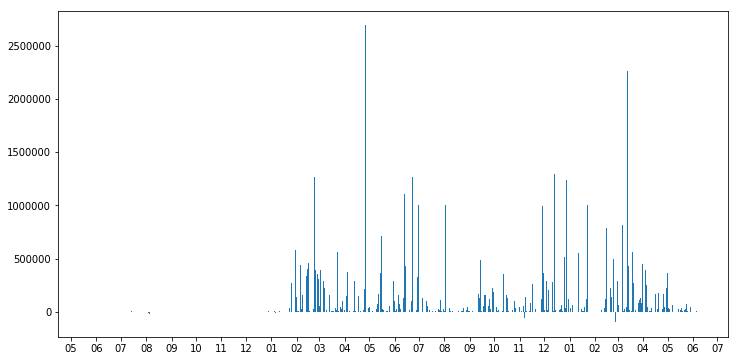

In [14]:
grouped_by_day_category_chart = grouped_by_day_category.set_index("date")
fig, ax = plt.subplots(figsize=[12, 6])
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m"))
ax.bar(grouped_by_day_category_chart.index, grouped_by_day_category_chart["total_amount_gop"])

<Container object of 457 artists>

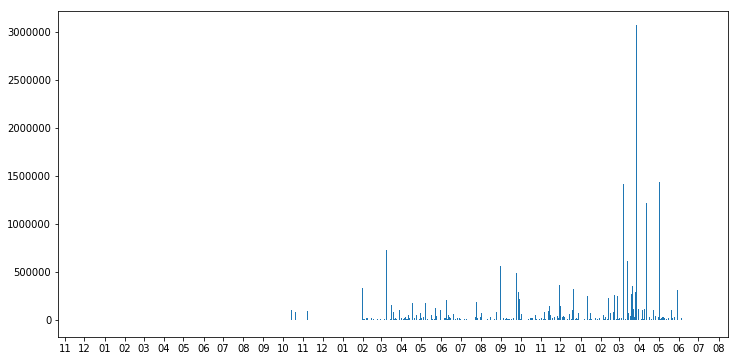

In [15]:
grouped_by_day_category_chart = grouped_by_day_category.set_index("date")
fig, ax = plt.subplots(figsize=[12, 6])
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m"))
ax.bar(grouped_by_day_category_chart.index, grouped_by_day_category_chart["total_amount_dem"])

## And let's visualize the 2014 cycle data by day.

In [16]:
grouped_by_day_category_14 = forbes_contributions_14.groupby(["date", "liberal_conservative"]).agg({"contributor_id": "nunique", "fectransid": "count", "amount": sum}).reset_index()
grouped_by_day_category_14.rename(columns={"contributor_id": "num_donors", "fectransid": "num_contributions", "amount": "total_amount"}, inplace=True)
grouped_by_day_category_14.head()

,date,liberal_conservative,num_donors,num_contributions,total_amount
0,2012-09-04,conservative/republican,1,3,-3400
1,2012-09-07,conservative/republican,1,1,5000
2,2012-09-24,conservative/republican,1,3,825
3,2012-10-15,conservative/republican,1,1,10000
4,2012-10-17,conservative/republican,1,1,-2500


Pivot dataframe to aggregate each day and category's data in a single row.

In [17]:
grouped_by_day_category_14 = pd.pivot_table(grouped_by_day_category_14, index="date",
                                         columns="liberal_conservative",
                                         values=["num_donors", "num_contributions", "total_amount"]).reset_index()                        
grouped_by_day_category_14.columns = ["date", "num_contributions_gop", "num_contributions_other",
                                   "num_contributions_dem", "num_donors_gop", "num_donors_dem",
                                   "num_donors_other", "total_amount_gop", "total_amount_dem",
                                  "total_amount_other"]
grouped_by_day_category_14.head()

,date,num_contributions_gop,num_contributions_other,num_contributions_dem,num_donors_gop,num_donors_dem,num_donors_other,total_amount_gop,total_amount_dem,total_amount_other
0,2012-09-04,3.00,nan,nan,1.00,nan,nan,"-3,400.00",nan,nan
1,2012-09-07,1.00,nan,nan,1.00,nan,nan,"5,000.00",nan,nan
2,2012-09-24,3.00,nan,nan,1.00,nan,nan,825.00,nan,nan
3,2012-10-15,1.00,nan,nan,1.00,nan,nan,"10,000.00",nan,nan
4,2012-10-17,1.00,nan,nan,1.00,nan,nan,"-2,500.00",nan,nan


Visualize it.

<Container object of 616 artists>

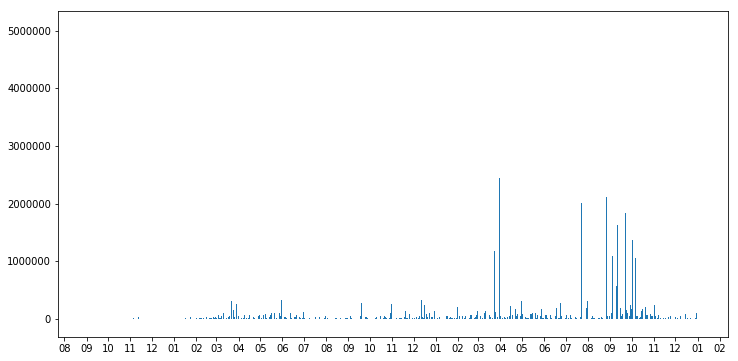

In [18]:
grouped_by_day_category_14_chart = grouped_by_day_category_14.set_index("date")
fig, ax = plt.subplots(figsize=[12, 6])
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m"))
ax.bar(grouped_by_day_category_14_chart.index, grouped_by_day_category_14_chart["total_amount_gop"])

<Container object of 616 artists>

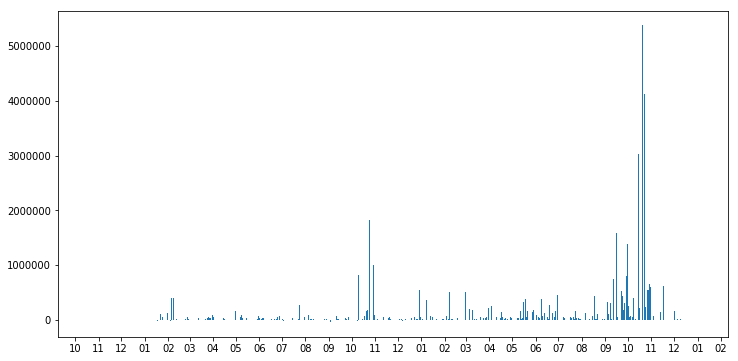

In [19]:
grouped_by_day_category_14_chart = grouped_by_day_category_14.set_index("date")
fig, ax = plt.subplots(figsize=[12, 6])
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m"))
ax.bar(grouped_by_day_category_14_chart.index, grouped_by_day_category_14_chart["total_amount_dem"])

## 2018 vs. 2014 side-to-side?

<Container object of 457 artists>

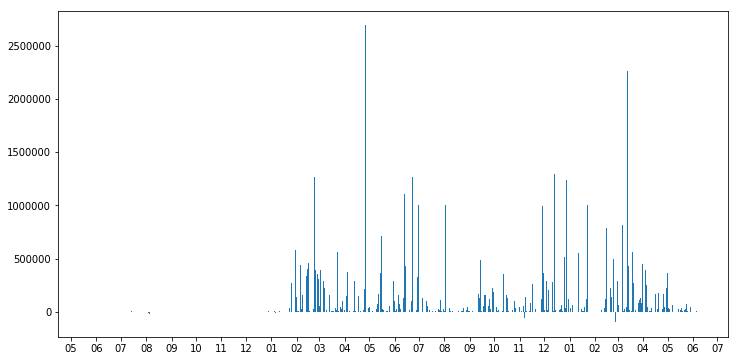

In [20]:
grouped_by_day_category_chart = grouped_by_day_category.set_index("date")
fig, ax = plt.subplots(figsize=[12, 6])
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m"))
ax.bar(grouped_by_day_category_chart.index, grouped_by_day_category_chart["total_amount_gop"]).str.contains("democratic", case=False)

<Container object of 616 artists>

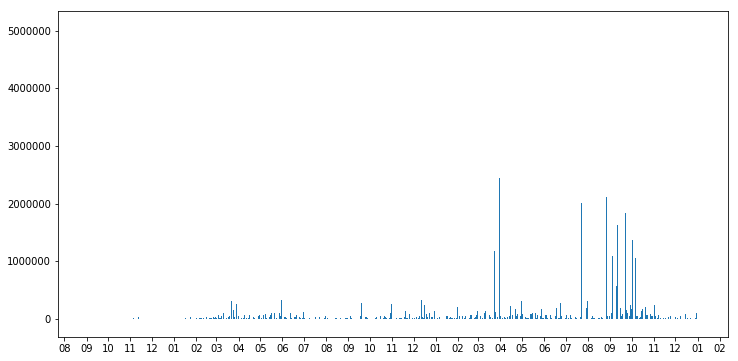

In [21]:
grouped_by_day_category_14_chart = grouped_by_day_category_14.set_index("date")
fig, ax = plt.subplots(figsize=[12, 6])
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m"))
ax.bar(grouped_by_day_category_14_chart.index, grouped_by_day_category_14_chart["total_amount_gop"])

## What about just during the week before and the week after the first House vote on the tax bill?

Filter down to just contributions during the week before and the week after the first House vote on the tax bill.

In [22]:
forbes_contributions_tax_weeks = forbes_contributions[(forbes_contributions["date"] >= "2017-11-09") & (forbes_contributions["date"] <= "2017-11-23")]
forbes_contributions_tax_weeks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199 entries, 4051 to 4249
Data columns (total 45 columns):
cycle_x                 199 non-null category
fectransid              199 non-null int64
contribid               199 non-null object
contrib                 199 non-null object
recipid_x               199 non-null object
orgname                 186 non-null object
ultorg_x                9 non-null object
realcode                199 non-null category
date                    199 non-null datetime64[ns]
amount                  199 non-null int64
street                  0 non-null float64
city                    199 non-null object
state                   199 non-null category
zip                     199 non-null object
recipcode_x             199 non-null category
type                    199 non-null category
cmteid                  199 non-null object
otherid                 47 non-null object
gender                  199 non-null category
microfilm               199 non-null obje

In [23]:
grouped_by_day_category_tax_weeks = forbes_contributions_tax_weeks.groupby(["date", "liberal_conservative"]).agg({"contributor_id": "nunique", "fectransid": "count", "amount": sum}).reset_index()
grouped_by_day_category_tax_weeks.rename(columns={"contributor_id": "num_donors", "fectransid": "num_contributions", "amount": "total_amount"}, inplace=True)
grouped_by_day_category_tax_weeks.head()

,date,liberal_conservative,num_donors,num_contributions,total_amount
0,2017-11-09,conservative/republican,3,6,8100
1,2017-11-09,liberal/democratic,4,9,1013000
2,2017-11-09,other,1,1,10
3,2017-11-10,conservative/republican,1,1,500
4,2017-11-13,conservative/republican,6,6,7700


Pivot dataframe to aggregate each day and category's data in a single row.

In [24]:
grouped_by_day_category_tax_weeks = pd.pivot_table(grouped_by_day_category_tax_weeks, index="date",
                                         columns="liberal_conservative",
                                         values=["num_donors", "num_contributions", "total_amount"]).reset_index()                        
grouped_by_day_category_tax_weeks.columns = ["date", "num_contributions_gop", "num_contributions_other",
                                   "num_contributions_dem", "num_donors_gop", "num_donors_dem",
                                   "num_donors_other", "total_amount_gop", "total_amount_dem",
                                  "total_amount_other"]
grouped_by_day_category_tax_weeks.head()

,date,num_contributions_gop,num_contributions_other,num_contributions_dem,num_donors_gop,num_donors_dem,num_donors_other,total_amount_gop,total_amount_dem,total_amount_other
0,2017-11-09,6.00,9.00,1.00,3.00,4.00,1.00,"8,100.00","1,013,000.00",10.00
1,2017-11-10,1.00,nan,nan,1.00,nan,nan,500.00,nan,nan
2,2017-11-13,6.00,31.00,nan,6.00,6.00,nan,"7,700.00","94,150.00",nan
3,2017-11-14,6.00,19.00,3.00,2.00,8.00,2.00,"89,100.00","147,945.00","10,015.00"
4,2017-11-15,9.00,6.00,3.00,7.00,3.00,3.00,"17,700.00","3,500.00","5,258.00"


Visualize it.

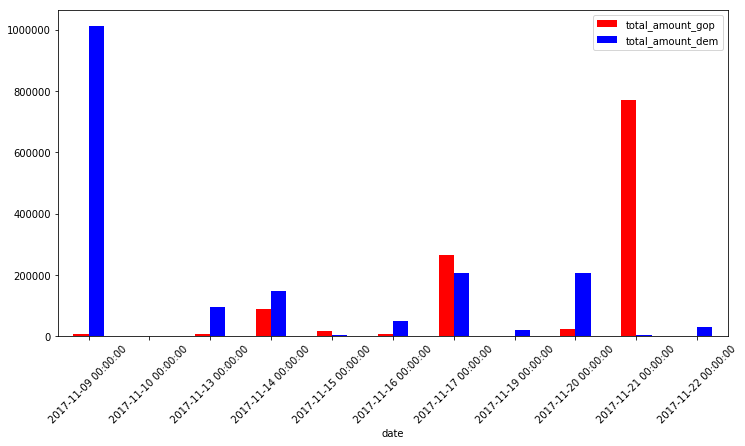

In [25]:
fig, ax = plt.subplots()
plt.xticks(rotation=45)
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
grouped_by_day_category_tax_weeks.plot(x="date", y=["total_amount_gop", "total_amount_dem"], kind="bar", ax=ax, figsize=[12, 6], color=["r", "b"])

## What about those receiving contributions during the week before the first House vote on the tax bill.

In [26]:
forbes_contributions_pre_vote = forbes_contributions[forbes_contributions["date"] < '2017-11-16']
pre_vote_grouped_by_category = forbes_contributions_pre_vote.groupby("liberal_conservative").agg({"contributor_id": "nunique", "fectransid": "count", "amount": sum}).reset_index()
pre_vote_grouped_by_category.rename(columns={"contributor_id": "num_donors", "fectransid": "num_contributions", "amount": "total_amount"}, inplace=True)
pre_vote_grouped_by_category["pct_total_amount"] = pre_vote_grouped_by_category["total_amount"] / pre_vote_grouped_by_category["total_amount"].sum()
pre_vote_grouped_by_category[pre_vote_grouped_by_category["total_amount"] > 0].sort_values("total_amount", ascending=False).head(25).reset_index(drop=True)

,liberal_conservative,num_donors,num_contributions,total_amount,pct_total_amount
0,conservative/republican,158,2218,36028128,0.70
1,liberal/democratic,126,1698,12943501,0.25
2,other,99,235,2322619,0.05


## What about those receiving contributions during the week after the first House vote on the tax bill.

In [61]:
forbes_contributions_post_vote = forbes_contributions[forbes_contributions["date"] > '2017-11-16']
post_vote_grouped_by_category = forbes_contributions_post_vote.groupby("liberal_conservative").agg({"contributor_id": "nunique", "fectransid": "count", "amount": sum}).reset_index()
post_vote_grouped_by_category.rename(columns={"contributor_id": "num_donors", "fectransid": "num_contributions", "amount": "total_amount"}, inplace=True)
post_vote_grouped_by_category["pct_total_amount"] = post_vote_grouped_by_category["total_amount"] / post_vote_grouped_by_category["total_amount"].sum()
post_vote_grouped_by_category[post_vote_grouped_by_category["total_amount"] > 0].sort_values("total_amount", ascending=False).head(25).reset_index(drop=True)

,liberal_conservative,num_donors,num_contributions,total_amount,pct_total_amount
0,liberal/democratic,107,1637,30303191,0.47
1,conservative/republican,140,1500,26401669,0.41
2,other,90,209,7436816,0.12


## And what about the day of the vote?

In [28]:
forbes_contributions_day_of_vote = forbes_contributions[forbes_contributions["date"] == '2017-11-16']
day_of_vote_grouped_by_category = forbes_contributions_day_of_vote.groupby("liberal_conservative").agg({"contributor_id": "nunique", "fectransid": "count", "amount": sum}).reset_index()
day_of_vote_grouped_by_category.rename(columns={"contributor_id": "num_donors", "fectransid": "num_contributions", "amount": "total_amount"}, inplace=True)
day_of_vote_grouped_by_category["pct_total_amount"] = day_of_vote_grouped_by_category["total_amount"] / day_of_vote_grouped_by_category["total_amount"].sum()
day_of_vote_grouped_by_category[day_of_vote_grouped_by_category["total_amount"] > 0].sort_values("total_amount", ascending=False).head(25).reset_index(drop=True)

,liberal_conservative,num_donors,num_contributions,total_amount,pct_total_amount
0,liberal/democratic,4,4,50000,0.89
1,conservative/republican,2,3,6400,0.11


## How many of those GOP donors who gave in the week following the vote also gave over the same period in 2014?

In [63]:
gop_forbes_contributions_post_vote = forbes_contributions_post_vote[forbes_contributions_post_vote["liberal_conservative"] == "conservative/republican"]
forbes_contributions_post_vote_14 = forbes_contributions_14[forbes_contributions_14["date"] > '2013-11-16']
gop_forbes_contributions_post_vote_14 = forbes_contributions_post_vote_14[forbes_contributions_post_vote_14["liberal_conservative"] == "conservative/republican"]
gop_forbes_contributions_post_vote_both_cycles = gop_forbes_contributions_post_vote.merge(gop_forbes_contributions_post_vote_14, on="contribid")
gop_forbes_contributions_post_vote_both_cycles.head()

,cycle_x_x,fectransid_x,contribid,contrib_x,recipid_x_x,orgname_x,ultorg_x_x,realcode_x,date_x,amount_x,street_x,city_x,...,primcode_y,source_y_y,sensitive_y,foreign_y,active_y,catcode_y,catname_y,catorder_y,industry_y,sector_y,sectorlong_y,liberal_conservative_y
0,2018,4022020181514119470,U00000002601,"HUBBARD, STANLEY",C00656157,Hubbard Broadcasting,NaN,C2100,2017-11-17,5000,nan,SAINT PAUL,...,Z5100,Rept,N,0,1,Z5100,Republican Party Committees,Z02,Party Committees,Party Cmte,Party Cmtes,conservative/republican
1,2018,4022020181514119470,U00000002601,"HUBBARD, STANLEY",C00656157,Hubbard Broadcasting,NaN,C2100,2017-11-17,5000,nan,SAINT PAUL,...,Z1100,Rept,N,0,1,Z1100,Republican Candidate Committees,Q16,Candidate Committees,Ideology/Single-Issue,Ideological/Single-Issue,conservative/republican
2,2018,4022020181514119470,U00000002601,"HUBBARD, STANLEY",C00656157,Hubbard Broadcasting,NaN,C2100,2017-11-17,5000,nan,SAINT PAUL,...,Z5100,Rept,n,0,1,Z5100,Republican Party Committees,Z02,Party Committees,Party Cmte,Party Cmtes,conservative/republican
3,2018,4022020181514119470,U00000002601,"HUBBARD, STANLEY",C00656157,Hubbard Broadcasting,NaN,C2100,2017-11-17,5000,nan,SAINT PAUL,...,Z1100,Rept,N,0,1,Z1100,Republican Candidate Committees,Q16,Candidate Committees,Ideology/Single-Issue,Ideological/Single-Issue,conservative/republican
4,2018,4022020181514119470,U00000002601,"HUBBARD, STANLEY",C00656157,Hubbard Broadcasting,NaN,C2100,2017-11-17,5000,nan,SAINT PAUL,...,Z1100,Rept,N,0,1,Z1100,Republican Candidate Committees,Q16,Candidate Committees,Ideology/Single-Issue,Ideological/Single-Issue,conservative/republican


In [51]:
gop_contributions = forbes_contributions[forbes_contributions["liberal_conservative"] == "conservative/republican"]
gop_donors = gop_contributions.groupby(["contribid"])["amount"].sum().reset_index()
top_gop_donors = gop_donors.sort_values("amount", ascending=False).head(10).reset_index(drop=True)
top_gop_donors

,contribid,amount
0,U00000033071,5896100
1,U00000038291,3463100
2,U00000035841,2370153
3,U00000032471,2178840
4,U00000034491,2145100
5,U00000034501,2137000
6,U00000036581,1856000
7,U0000000074A,1727000
8,U00000001751,1691200
9,U00000036551,1690200


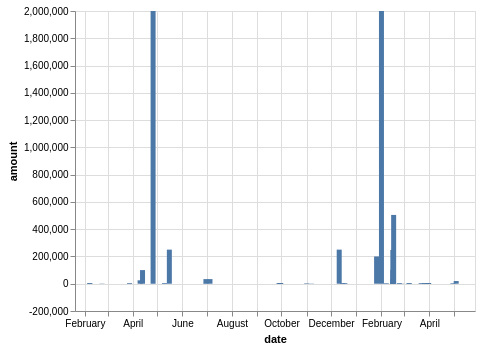

In [52]:
alt.Chart(forbes_contributions[forbes_contributions["contribid"] == "U00000033071"]).mark_bar().encode(
x="date",
y="amount")

In [53]:
gop_contributions_14 = forbes_contributions_14[forbes_contributions_14["liberal_conservative"] == "conservative/republican"]
gop_donors_14= gop_contributions_14.groupby(["contribid"])["amount"].sum().reset_index()
top_gop_donors_14 = gop_donors_14.sort_values("amount", ascending=False).head(10).reset_index(drop=True)
top_gop_donors_14

,contribid,amount
0,U00000003101,5227300
1,U00000034771,5158600
2,U00000002491,3216200
3,U00000038031,2769300
4,U00000001751,2756200
5,U00000036461,2600000
6,U00000034781,2277900
7,U00000036551,1426450
8,U0000000074A,1197600
9,U00000038301,1179600


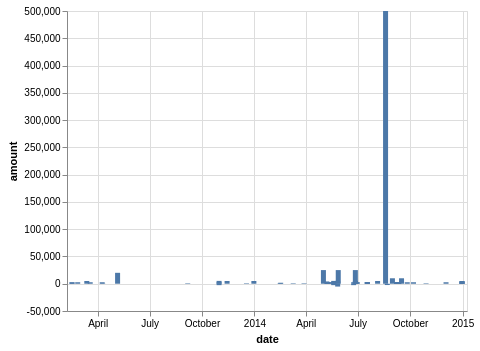

In [54]:
alt.Chart(forbes_contributions_14[forbes_contributions_14["contribid"] == "U00000033071"]).mark_bar().encode(
x="date",
y="amount")

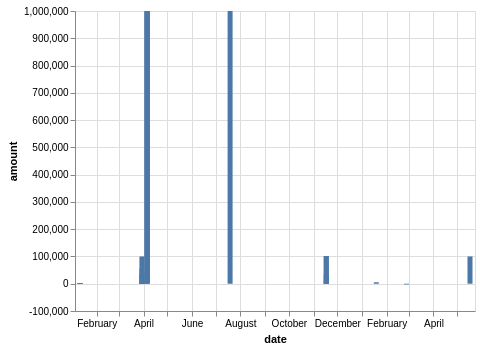

In [56]:
alt.Chart(forbes_contributions[forbes_contributions["contribid"] == "U00000038291"]).mark_bar().encode(
x="date",
y="amount")